# Glow Mini sur MNIST
### réimplémentation de Glow (Kingma & Dhariwal, 2018)

Ce notebook implémente un modèle de génération par flots (normalizing flow) inspiré de Glow, adapté à MNIST (images 1×28×28).

Objectifs :
- entraîner un modèle à vraisemblance exacte via la formule du changement de variable ;
- comparer deux mélangeurs de canaux : permutation aléatoire vs convolution 1×1 inversible ;
- générer, reconstruire et interpoler dans l'espace latent.

Notations (simplifiées) :
- on applique un pré-traitement logit_preprocess qui mappe $x\in[0,1]$ vers $y\in\mathbb{R}$ et renvoie le terme de jacobien associé ;
- le flot apprend une bijection $f$ telle que $z=f(y)$ avec un prior gaussien standard $p(z)$ ;
- le log-likelihood exact s'obtient par $\log p(y)=\log p(z)+\log\left|\det \frac{\partial f}{\partial y}\right|.$

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from contextlib import contextmanager

from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import umap

## Pré-traitement des pixels et mesure en bits/dim

Les flows continus comme Glow s'appliquent naturellement à des données réelles. Or MNIST est discret (0..255). On suit donc une recette standard :

1. Déquantification uniforme : on ajoute un bruit uniforme avant de re-normaliser (approximation d'une densité continue).
2. Logit transform : on mappe $(0,1)$ vers $\mathbb{R}$ pour éviter les bords et rendre la variable compatible avec un prior gaussien.

Le pré-traitement renvoie aussi le log-déterminant du jacobien de cette transformation (terme à ajouter au log-likelihood du flot).

In [2]:
def log_normal_standard(z):
    return -0.5 * (math.log(2 * math.pi) + z.pow(2)).flatten(1).sum(dim=1)

def bits_per_dim_from_logpx(log_px, C, H, W):
    D = C * H * W
    log_px = log_px - D * math.log(256.0)

    nll = -log_px.mean()
    bpd = nll / (math.log(2.0) * D)
    return nll, bpd

def dequantize(x):
    x = x * 255.0
    x = x + torch.rand_like(x)
    x = x / 256.0
    return x

def logit_preprocess(x, alpha=1e-2):
    """Uniform dequantization + logit transform to R."""
    x = dequantize(x)
    x = x * (1 - 2 * alpha) + alpha
    x = x.clamp(alpha, 1 - alpha)

    # log |det J| from scaling + logit
    logdet = math.log(1 - 2 * alpha) * x[0].numel()
    logdet = x.new_full((x.size(0),), logdet)
    logdet = logdet + (-torch.log(x) - torch.log1p(-x)).flatten(1).sum(dim=1)

    y = torch.log(x) - torch.log1p(-x)
    return y, logdet

def logit_postprocess(y, alpha=1e-2):
    x = torch.sigmoid(y)
    x = (x - alpha) / (1 - 2 * alpha)
    return x.clamp(0.0, 1.0)


## Squeeze / Unsqueeze (réorganisation espace↔canaux)

Glow utilise une opération squeeze qui convertit un bloc spatial $2\times2$ en canaux :
- $(B,C,H,W) \rightarrow (B,4C,H/2,W/2)$.

Cela augmente le nombre de canaux tout en réduisant la résolution. L'opération inverse unsqueeze restaure la résolution.

Dans un flow, c'est une permutation/décomposition réversible : son jacobien a un déterminant de module 1.


In [3]:
def squeeze2x2(x):
    B, C, H, W = x.shape
    x = x.view(B, C, H//2, 2, W//2, 2)
    x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
    return x.view(B, C*4, H//2, W//2)

def unsqueeze2x2(x):
    B, C, H, W = x.shape
    x = x.view(B, C//4, 2, 2, H, W)
    x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
    return x.view(B, C//4, H*2, W*2)

## ActNorm

ActNorm (introduit dans Glow) est une normalisation apprise par canal :
$$y = (x + b) \odot \exp(s).$$

Point clé : les paramètres sont initialisés à partir du premier batch (data-dependent initialization) pour rendre la sortie approximativement centrée et de variance 1. Ensuite, on apprend $b$ et $s$.

Le log-déterminant est simple car la transformation est diagonale (par canal et par position) : il vaut $(H\cdot W)\sum_c s_c$.


In [4]:
class ActNorm(nn.Module):
    def __init__(self, C, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.bias = nn.Parameter(torch.zeros(1, C, 1, 1))
        self.log_scale = nn.Parameter(torch.zeros(1, C, 1, 1))
        self.initialized = False

    @torch.no_grad()
    def initialize(self, x):
        mean = x.mean(dim=[0,2,3], keepdim=True)
        std = x.std(dim=[0,2,3], keepdim=True)
        self.bias.data = -mean
        self.log_scale.data = torch.log(1.0/(std + self.eps))
        self.initialized = True

    def forward(self, x):
        if self.training and (not self.initialized):
            self.initialize(x)
        y = (x + self.bias) * torch.exp(self.log_scale)
        B, C, H, W = x.shape
        logdet = (H*W) * self.log_scale.view(1, C).sum(dim=1)
        return y, logdet.expand(B)

    def inverse(self, y):
        return y * torch.exp(-self.log_scale) - self.bias

## Mélange des canaux : permutation vs convolution 1×1 inversible

Les couches de couplage n'altèrent qu'une partie des canaux à la fois. Pour que l'information se propage entre canaux au fil des blocs, Glow intercale une opération de mélange :

- Permutation de canaux (baseline) : logdet = 0 (c'est une permutation).
- Convolution 1×1 inversible (Glow) : à chaque position spatiale $(h,w)$, on applique la même matrice $W\in\mathbb{R}^{C\times C}$.

Le facteur $(H\cdot W)$ apparaît car la même matrice agit sur chaque pixel.


In [5]:
class ChannelPermute(nn.Module):
    def __init__(self, C):
        super().__init__()
        perm = torch.randperm(C)
        inv = torch.empty_like(perm)
        inv[perm] = torch.arange(C)
        self.register_buffer("perm", perm)
        self.register_buffer("invperm", inv)

    def forward(self, x):
        # logdet = 0
        return x[:, self.perm, :, :], torch.zeros(x.size(0), device=x.device)

    def inverse(self, y):
        return y[:, self.invperm, :, :]

In [6]:
class Invertible1x1Conv(nn.Module):
    def __init__(self, C):
        super().__init__()
        # orthogonal init
        w = torch.linalg.qr(torch.randn(C, C)).Q
        self.weight = nn.Parameter(w)

    def forward(self, x):
        B, C, H, W = x.shape
        Wmat = self.weight
        y = F.conv2d(x, Wmat.view(C, C, 1, 1))
        logdetW = torch.slogdet(Wmat)[1]
        logdet = (H*W) * logdetW
        return y, logdet.expand(B)

    def inverse(self, y):
        C = y.size(1)
        Winv = torch.inverse(self.weight)
        return F.conv2d(y, Winv.view(C, C, 1, 1))

## Détail du jacobien de la convolution 1×1 inversible

Soit une entrée $x\in\mathbb{R}^{B\times C\times H\times W}$ et une matrice de poids $W\in\mathbb{R}^{C\times C}$. La convolution 1×1 agit indépendamment sur chaque position spatiale.

Pour un exemple (batch omis) et une position spatiale $(h,w)$ :
$$y_{:,h,w} = W\,x_{:,h,w}, \qquad W\ \text{identique pour tous les }(h,w).$$

Si l'on « aplati » les canaux×pixels en un vecteur $\mathrm{vec}(x)\in\mathbb{R}^{C\cdot H\cdot W},$
alors la transformation est linéaire : $\mathrm{vec}(y)=J\,\mathrm{vec}(x)$ où la jacobienne $J$ est bloc-diagonale :
- il y a $H\cdot W$ blocs (un par pixel),
- chaque bloc est exactement la même matrice $W$.

Donc $\det(J)=\prod_{h,w}\det(W)=\det(W)^{H\cdot W},$ et le terme utilisé en log-vraisemblance vaut : $\log|\det(J)|=(H\cdot W)\,\log|\det(W)|.$

C'est la raison du facteur $H*W$ dans le code.


## Couplage affine (Affine Coupling)

Une couche de couplage affine sépare les canaux en deux blocs $(x_1, x_2)$ :
- un petit réseau convolutif produit des paramètres $(s,t)=\mathrm{NN}(x_1)$ ;
- on transforme l'autre moitié : $y_2 = x_2 \odot \exp(s) + t$ ;
- $x_1$ est recopié (à l'identique) pour garantir l'inversibilité.

Le jacobien est triangulaire : le log-déterminant se résume à la somme de $s$ sur toutes les dimensions transformées.

Dans Glow, la dernière couche du réseau de couplage est souvent initialisée à zéro pour démarrer proche de l'identité (ce qui est fait ici).


In [7]:
class CouplingNN(nn.Module):
    def __init__(self, in_ch, hidden_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, hidden_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_ch, hidden_ch, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_ch, out_ch, 3, padding=1),
        )
        nn.init.zeros_(self.net[-1].weight)
        nn.init.zeros_(self.net[-1].bias)

    def forward(self, x):
        return self.net(x)

class AffineCoupling(nn.Module):
    def __init__(self, C, hidden=64, clamp=2.0):
        super().__init__()
        assert C % 2 == 0
        self.nn = CouplingNN(C//2, hidden, C)  # outputs s,t for other half
        self.clamp = clamp

    def forward(self, x):
        x1, x2 = torch.chunk(x, 2, dim=1)
        h = self.nn(x1)
        s, t = torch.chunk(h, 2, dim=1)
        s = self.clamp * torch.tanh(s / self.clamp)

        y2 = x2 * torch.exp(s) + t
        y = torch.cat([x1, y2], dim=1)
        logdet = s.flatten(1).sum(dim=1)
        return y, logdet

    def inverse(self, y):
        y1, y2 = torch.chunk(y, 2, dim=1)
        h = self.nn(y1)
        s, t = torch.chunk(h, 2, dim=1)
        s = self.clamp * torch.tanh(s / self.clamp)

        x2 = (y2 - t) * torch.exp(-s)
        return torch.cat([y1, x2], dim=1)

## Bloc de flot (FlowStep)

Un bloc Glow standard enchaîne typiquement :
1. ActNorm
2. mélange des canaux (permute ou conv 1×1 inversible)
3. couplage affine

Chaque sous-couche est inversible et fournit un logdet.
Le logdet total du bloc est la somme des logdet.


In [8]:
class FlowStep(nn.Module):
    def __init__(self, C, hidden=64, mixer="conv1x1"):
        super().__init__()
        self.actnorm = ActNorm(C)
        self.mixer = Invertible1x1Conv(C) if mixer == "conv1x1" else ChannelPermute(C)
        self.coupling = AffineCoupling(C, hidden=hidden)

    def forward(self, x):
        x, ld1 = self.actnorm(x)
        x, ld2 = self.mixer(x)
        x, ld3 = self.coupling(x)
        return x, (ld1 + ld2 + ld3)

    def inverse(self, z):
        z = self.coupling.inverse(z)
        z = self.mixer.inverse(z)
        z = self.actnorm.inverse(z)
        return z

## Architecture multi-échelle (multi-scale)

Glow utilise une architecture multi-échelle : après quelques FlowSteps, on factorise une partie des canaux vers l'espace latent (split), et on continue le flot sur le reste à plus basse résolution.

Ici, on implémente une version "mini" à 2 niveaux :
- Niveau 1 : squeeze → K steps → split pour produire $z_1$ ;
- Niveau 2 : squeeze → K steps → reste comme $z_2$.

Le prior est un gaussien standard indépendant sur $(z_1, z_2)$.


In [9]:
class GlowMiniMultiScale(nn.Module):
    """
    2-level multi-scale:
      Level1: squeeze -> K steps -> split (half to z1)
      Level2: squeeze -> K steps -> rest to z2
    """
    def __init__(self, K=4, hidden=64, mixer="conv1x1"):
        super().__init__()
        self.K = K
        self.hidden = hidden
        self.mixer = mixer

        self.level1 = nn.ModuleList([FlowStep(4, hidden, mixer=mixer) for _ in range(K)])
        self.level2 = nn.ModuleList([FlowStep(8, hidden, mixer=mixer) for _ in range(K)])

    def forward(self, x):
        logdet_total = torch.zeros(x.size(0), device=x.device)

        h = squeeze2x2(x)
        for step in self.level1:
            h, ld = step(h)
            logdet_total += ld

        z1, h = torch.chunk(h, 2, dim=1)

        h = squeeze2x2(h)
        for step in self.level2:
            h, ld = step(h)
            logdet_total += ld

        z2 = h

        log_pz = log_normal_standard(z1) + log_normal_standard(z2)
        log_px = log_pz + logdet_total

        return (z1, z2), log_px

    def inverse(self, z1, z2):
        # invert Level 2
        h = z2
        for step in reversed(self.level2):
            h = step.inverse(h)
        h = unsqueeze2x2(h)  # (B,2,14,14)

        # concat with z1 to reconstruct Level1 output
        h = torch.cat([z1, h], dim=1)  # (B,4,14,14)

        # invert Level 1
        for step in reversed(self.level1):
            h = step.inverse(h)
        x = unsqueeze2x2(h)  # (B,1,28,28)
        return x

    @torch.no_grad()
    def sample(self, n, device, temperature=0.7, postprocess_fn=None):
        z1 = temperature * torch.randn(n, 2, 14, 14, device=device)
        z2 = temperature * torch.randn(n, 8, 7, 7, device=device)
        x = self.inverse(z1, z2)
        if postprocess_fn is not None:
            x = postprocess_fn(x)
        return x

    @torch.no_grad()
    def encode(self, x):
        (z1, z2), _ = self.forward(x)
        return z1, z2

    @torch.no_grad()
    def decode(self, z1, z2, postprocess_fn=None):
        x = self.inverse(z1, z2)
        if postprocess_fn is not None:
            x = postprocess_fn(x)
        return x


## Données, objectif d'entraînement et EMA

Cette section définit :
- le chargement de MNIST + split train/val
- l'évaluation en bpd
- une boucle d'entraînement maximisant le log-likelihood exact
- une EMA des poids, fréquente en génération : on évalue/génère souvent avec les poids lissés

In [10]:
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {
            name: p.detach().clone()
            for name, p in model.named_parameters()
            if p.requires_grad
        }
        self.backup = {}

    @torch.no_grad()
    def update(self, model):
        for name, p in model.named_parameters():
            if not p.requires_grad:
                continue
            self.shadow[name].mul_(self.decay).add_(p.detach(), alpha=1 - self.decay)

    def apply(self, model):
        self.backup = {}
        for name, p in model.named_parameters():
            if not p.requires_grad:
                continue
            self.backup[name] = p.detach().clone()
            p.data.copy_(self.shadow[name])

    def restore(self, model):
        if not self.backup:
            return
        for name, p in model.named_parameters():
            if p.requires_grad and name in self.backup:
                p.data.copy_(self.backup[name])
        self.backup = {}


def make_loaders(batch_size, seed=0):
    transform = transforms.ToTensor()
    ds = datasets.MNIST("./data", train=True, download=True, transform=transform)

    n_train = int(0.92 * len(ds))  # ~55k/5k split
    n_val = len(ds) - n_train
    train_ds, val_ds = random_split(ds, [n_train, n_val], generator=torch.Generator().manual_seed(seed))

    common = dict(batch_size=batch_size, num_workers=2, pin_memory=torch.cuda.is_available())
    train_loader = DataLoader(train_ds, shuffle=True, **common)
    val_loader = DataLoader(val_ds, shuffle=False, **common)
    return train_loader, val_loader


@torch.no_grad()
def evaluate_bpd(model, loader, device, alpha=1e-2):
    model.eval()
    total_bpd = 0.0
    total = 0
    for x, _ in loader:
        x = x.to(device)
        x_proc, logdet = logit_preprocess(x, alpha=alpha)
        (_, _), log_px = model(x_proc)
        log_px = log_px + logdet
        _, bpd = bits_per_dim_from_logpx(log_px, C=1, H=28, W=28)
        total_bpd += bpd.item() * x.size(0)
        total += x.size(0)
    return total_bpd / total


@contextmanager
def ema_scope(model, ema):
    if ema is None:
        yield
        return
    ema.apply(model)
    try:
        yield
    finally:
        ema.restore(model)


def train_one(
    model,
    loader,
    device,
    epochs=10,
    lr=1e-3,
    alpha=1e-2,
    warmup_steps=500,
    weight_decay=1e-5,
    max_grad_norm=5.0,
    ema_decay=0.999,
    val_loader=None,
):
    opt = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99), weight_decay=weight_decay)
    ema = EMA(model, decay=ema_decay) if ema_decay else None
    global_step = 0

    for ep in range(epochs):
        model.train()
        bpd_running = 0.0
        total = 0

        for x, _ in loader:
            x = x.to(device)
            x, logdet = logit_preprocess(x, alpha=alpha)

            (_, _), log_px = model(x)
            log_px = log_px + logdet

            nll, bpd = bits_per_dim_from_logpx(log_px, C=1, H=28, W=28)

            opt.zero_grad(set_to_none=True)
            nll.backward()
            if max_grad_norm:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            opt.step()
            if ema:
                ema.update(model)

            global_step += 1
            if warmup_steps:
                warmup_scale = min(1.0, global_step / warmup_steps)
                for g in opt.param_groups:
                    g["lr"] = lr * warmup_scale

            bpd_running += bpd.item() * x.size(0)
            total += x.size(0)

        bpd_epoch = bpd_running / total
        msg = f"Epoch {ep+1:02d} | bits/dim: {bpd_epoch:.4f} | lr: {opt.param_groups[0]['lr']:.1e}"

        if val_loader is not None:
            with ema_scope(model, ema):
                val_bpd = evaluate_bpd(model, val_loader, device, alpha=alpha)
            msg += f" | val bpd: {val_bpd:.4f}"

        print(msg)

    return ema


## Configuration d'entraînement

On fixe ici les hyperparamètres (K, largeur du réseau de couplage, batch size, LR, etc.) et on instancie deux modèles :
- mixer="conv1x1" (version Glow)
- mixer="permute" (baseline)

L'entraînement effectif est commenté dans la cellule suivante afin de pouvoir charger directement des checkpoints pré-entraînés.


In [11]:
torch.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

cfg = dict(
    epochs=35,
    batch_size=256,
    K=16,
    hidden=256,
    lr=1e-3,
    warmup_steps=1000,
    weight_decay=1e-5,
    max_grad_norm=5.0,
    alpha=1e-2,
    ema_decay=0.999,
    temperature=0.7,
)

train_loader, val_loader = make_loaders(cfg["batch_size"])

print("Training CONV1x1 model (logit preprocess + EMA)")
model_conv = GlowMiniMultiScale(K=cfg["K"], hidden=cfg["hidden"], mixer="conv1x1").to(device)
model_perm = GlowMiniMultiScale(K=cfg["K"], hidden=cfg["hidden"], mixer="permute").to(device)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.0MB/s]


Training CONV1x1 model (logit preprocess + EMA)


In [12]:
# ema_conv = train_one(
#     model_conv,
#     train_loader,
#     device,
#     epochs=cfg["epochs"],
#     lr=cfg["lr"],
#     alpha=cfg["alpha"],
#     warmup_steps=cfg["warmup_steps"],
#     weight_decay=cfg["weight_decay"],
#     max_grad_norm=cfg["max_grad_norm"],
#     ema_decay=cfg["ema_decay"],
#     val_loader=val_loader,
# )

# print("Sampling sanity-check")
# with ema_scope(model_conv, ema_conv):
#     samples = model_conv.sample(
#         16,
#         device,
#         temperature=cfg["temperature"],
#         postprocess_fn=lambda y: logit_postprocess(y, alpha=cfg["alpha"]),
#     )
# print(samples.shape, samples.min().item(), samples.max().item())

## Chargement et mise en mode évaluation

On charge les poids


In [13]:
#Pour eviter de recalculer les poids on va chercher ceux qu'on a déjà fait sur le repo
!git clone https://github.com/Nocimaa/GenAI

Cloning into 'GenAI'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 32 (delta 0), reused 1 (delta 0), pack-reused 29 (from 1)
Receiving objects: 100% (32/32), 53.33 MiB | 22.97 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [14]:
ckpt_conv_path = "GenAI/glow_conv1x1_ckpt.pt"
ckpt_permute_path = "GenAI/glow_permute_ckpt.pt"

In [15]:
checkpoint_conv = torch.load(ckpt_conv_path, map_location="cuda", weights_only=False)
checkpoint_permute = torch.load(ckpt_permute_path, map_location="cuda", weights_only=False)

In [16]:
model_conv = GlowMiniMultiScale(K=cfg["K"], hidden=cfg["hidden"], mixer="conv1x1").to(device)
model_perm = GlowMiniMultiScale(K=cfg["K"], hidden=cfg["hidden"], mixer="permute").to(device)

model_conv.load_state_dict(checkpoint_conv["model"], strict=True)
model_conv.load_state_dict(checkpoint_conv["ema"].shadow, strict=False)
model_perm.load_state_dict(checkpoint_permute["model"], strict=True)
model_perm.load_state_dict(checkpoint_permute["ema"].shadow, strict=False)

# ema_conv = checkpoint_conv["ema"]
# ema_perm = checkpoint_permute["ema"]

cfg_conv = checkpoint_conv["cfg"]
cfg_perm = checkpoint_permute["cfg"]

model_conv.eval()
model_perm.eval()

print()

## Visualisations : génération, reconstruction, interpolation

On définit ci-dessous quelques utilitaires pour :
- générer des échantillons depuis $z\sim\mathcal{N}(0,I)$ puis décoder ;
- reconstruire des images en encodant puis décodant (sanity-check de l'inversibilité) ;
- interpoler entre deux latents $(z_1,z_2)$ et observer la trajectoire dans l'espace des images.

In [17]:
def _show_grid(x, title="", ncols=5):
    """
    x: Tensor [B,1,H,W] sur CPU ou GPU
    """
    x = x.detach().cpu()
    B = x.size(0)
    nrows = math.ceil(B / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))
    if nrows == 1:
        axes = [axes]
    fig.suptitle(title)

    idx = 0
    for i in range(nrows):
        row_axes = axes[i] if isinstance(axes[i], (list, tuple)) else (axes[i] if hasattr(axes[i], "__len__") else [axes[i]])
        if hasattr(axes, "shape") and len(axes.shape) == 2:
            row_axes = axes[i]

        for j in range(ncols):
            ax = row_axes[j] if hasattr(row_axes, "__len__") else row_axes
            ax.axis("off")
            if idx < B:
                ax.imshow(x[idx, 0], cmap="gray")
            idx += 1

    plt.tight_layout()
    plt.show()

@torch.no_grad()
def generate_and_show(model, n_samples, device, title="Generated samples", alpha=1e-2, temperature=0.8, ema=None, ncols=5):
    model.eval()
    with ema_scope(model, ema):
        x = model.sample(
            n_samples,
            device,
            temperature=temperature,
            postprocess_fn=lambda y: logit_postprocess(y, alpha=alpha),
        )
    _show_grid(x, title=title, ncols=ncols)

@torch.no_grad()
def reconstruct_and_show(model, loader, device, n=8, alpha=1e-2, ema=None):

    model.eval()

    x, _ = next(iter(loader))
    x = x[:n].to(device)
    x_proc, _ = logit_preprocess(x, alpha=alpha)

    with ema_scope(model, ema):
        z1, z2 = model.encode(x_proc)
        x_rec = model.decode(
            z1, z2,
            postprocess_fn=lambda y: logit_postprocess(y, alpha=alpha),
        )

    _show_grid(x, title="Original MNIST", ncols=min(n, 8))
    _show_grid(x_rec, title="Reconstructions (Glow)", ncols=min(n, 8))

@torch.no_grad()
def interpolate_and_show(model, loader, device, idx_a=0, idx_b=1, steps=12, alpha=1e-2, ema=None, title="Latent interpolation"):
    model.eval()

    x, _ = next(iter(loader))
    x = x.to(device)

    xa = x[idx_a:idx_a+1]
    xb = x[idx_b:idx_b+1]
    xa_proc, _ = logit_preprocess(xa, alpha=alpha)
    xb_proc, _ = logit_preprocess(xb, alpha=alpha)

    with ema_scope(model, ema):
        z1a, z2a = model.encode(xa_proc)
        z1b, z2b = model.encode(xb_proc)

        imgs = []
        for t in torch.linspace(0, 1, steps, device=device):
            z1 = (1 - t) * z1a + t * z1b
            z2 = (1 - t) * z2a + t * z2b
            xi = model.decode(z1, z2, postprocess_fn=lambda y: logit_postprocess(y, alpha=alpha))
            imgs.append(xi[0:1])

    seq = torch.cat(imgs, dim=0)

    _show_grid(torch.cat([xa, xb], dim=0), title="Endpoints (real)", ncols=2)
    _show_grid(seq, title=title, ncols=min(steps, 12))


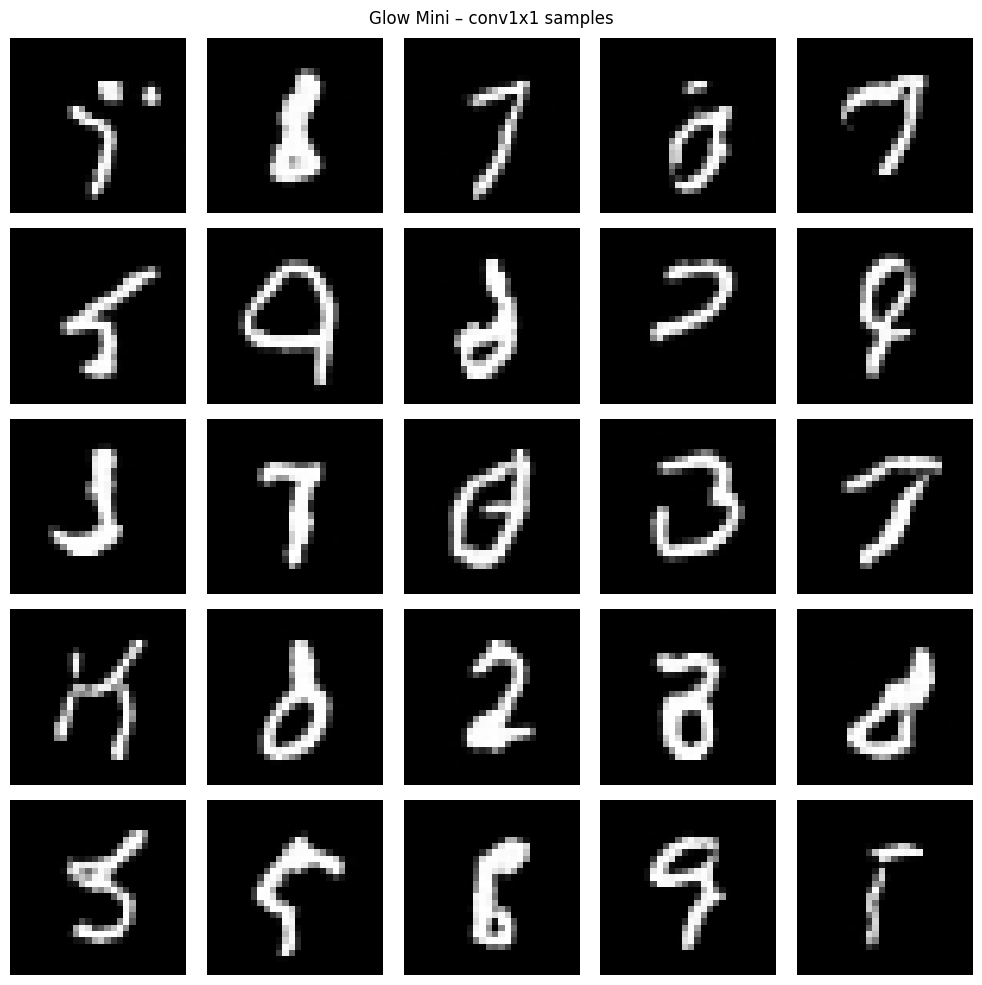

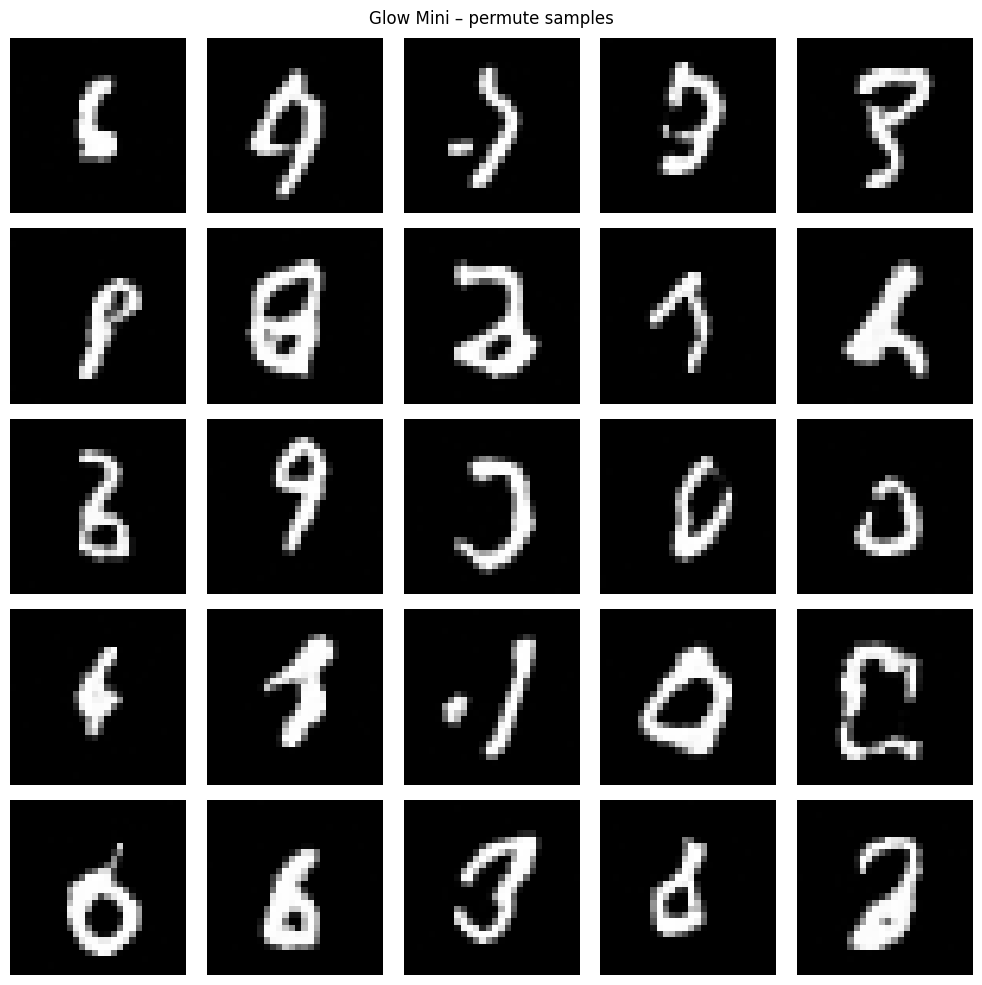

In [18]:
generate_and_show(model_conv, n_samples=25, device=device,
                  alpha=cfg_conv["alpha"], temperature=cfg_conv["temperature"], title="Glow Mini – conv1x1 samples", ncols=5)

generate_and_show(model_perm, n_samples=25, device=device,
                  alpha=cfg_perm["alpha"], temperature=cfg_perm["temperature"], title="Glow Mini – permute samples", ncols=5)

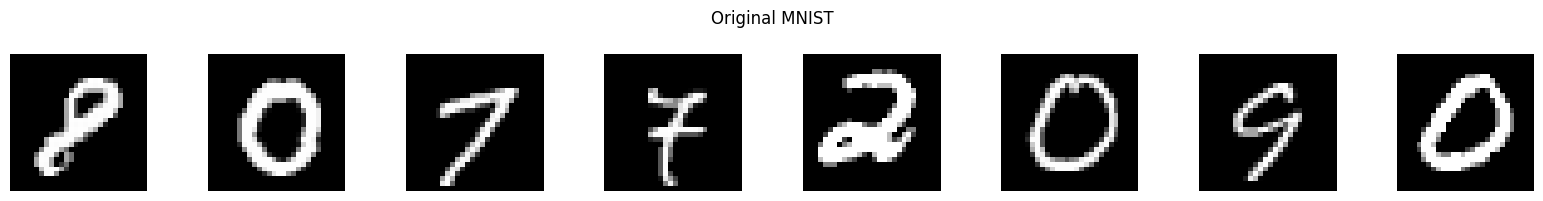

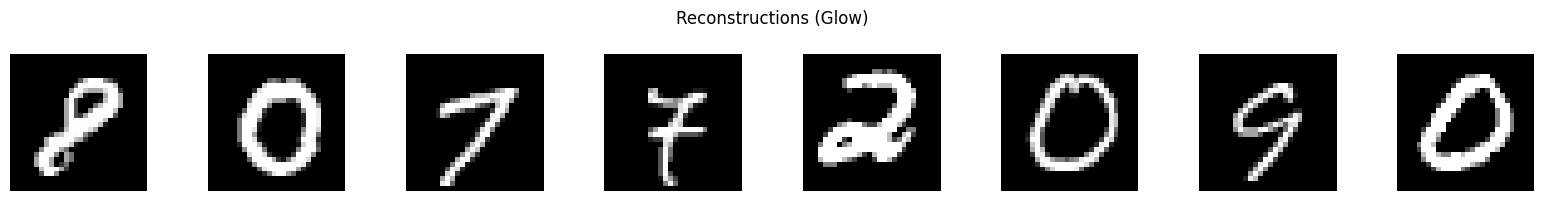

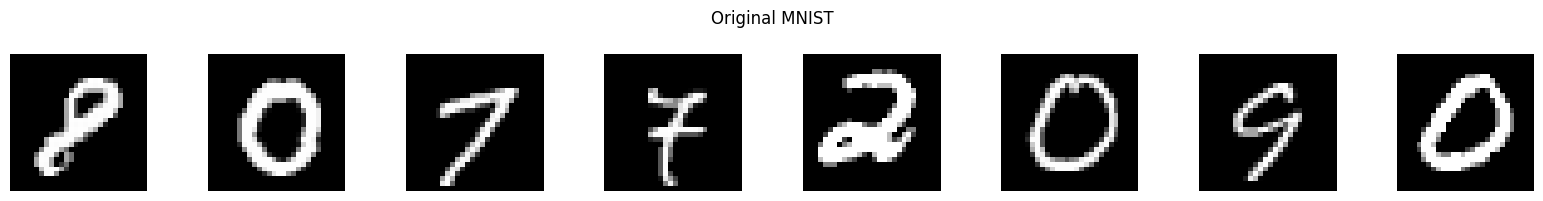

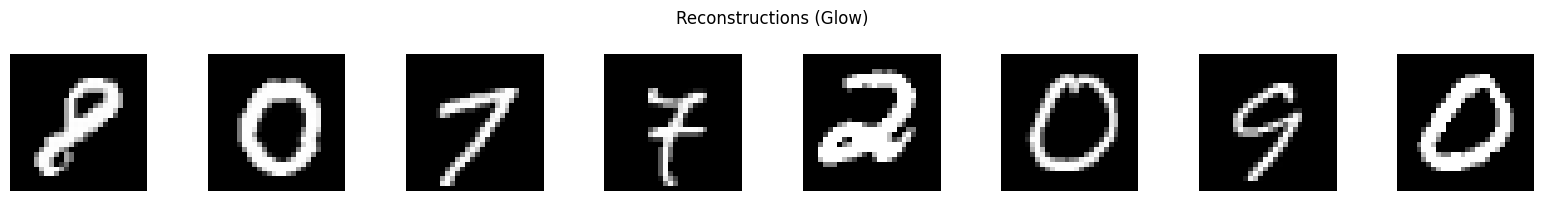

In [19]:
reconstruct_and_show(model_conv, val_loader, device, n=8, alpha=cfg_conv["alpha"])
reconstruct_and_show(model_perm, val_loader, device, n=8, alpha=cfg_perm["alpha"])


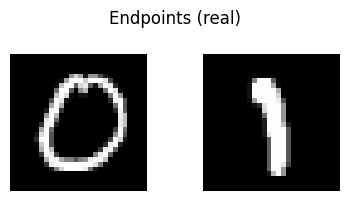

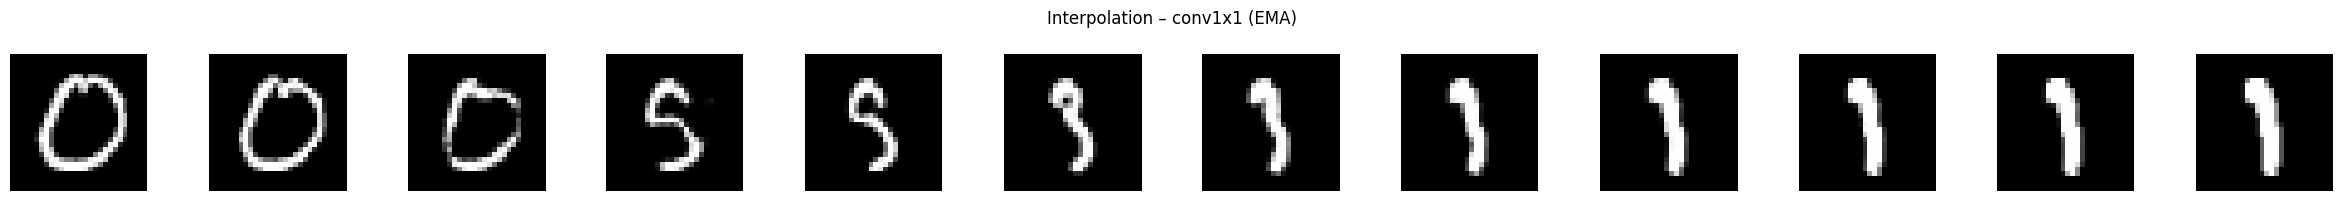

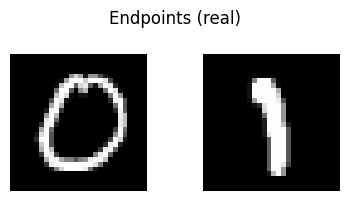

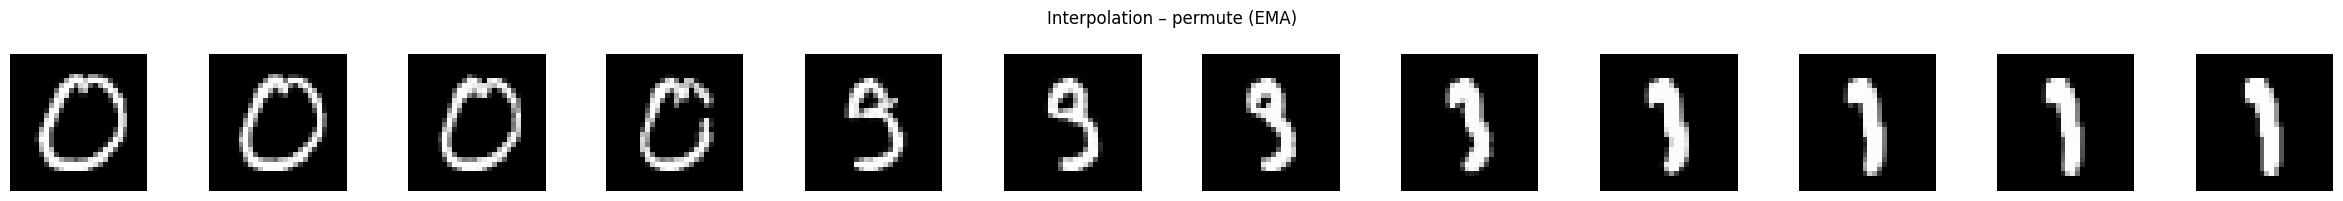

In [20]:
interpolate_and_show(model_conv, val_loader, device, idx_a=5, idx_b=12, steps=12,
                     alpha=cfg_conv["alpha"], title="Interpolation – conv1x1 (EMA)")

interpolate_and_show(model_perm, val_loader, device, idx_a=5, idx_b=12, steps=12,
                     alpha=cfg_perm["alpha"], title="Interpolation – permute (EMA)")


# Exploration de l'espace latent

Objectifs :
- Projeter les latents $(z_1, z_2)$ en 2D/3D (PCA en base, puis t-SNE/UMAP si disponibles) et colorer par label MNIST.
- Interpoler dans l'espace latent (linéaire vs *slerp*), et surtout interpoler séparément :
  - sur $z_1$ seul (niveau 1, plus « grossier »)
  - sur $z_2$ seul (niveau 2, plus « fin »)
- Vérifier quelques propriétés statistiques : histogrammes de la moyenne/écart-type par dimension, et visualisation de certaines dimensions.
- Explorer des axes latents : variations le long des premières composantes PCA et décodage des images correspondantes.


In [21]:
@torch.no_grad()
def collect_latents(model, loader, device, *, alpha=1e-2, max_samples=5000):
    model.eval()
    xs, ys = [], []
    z1_shape, z2_shape = None, None
    n = 0
    for x, y in loader:
        if n >= max_samples:
            break
        x = x.to(device)
        x_proc, _ = logit_preprocess(x, alpha=alpha)
        z1, z2 = model.encode(x_proc)
        if z1_shape is None:
            z1_shape = tuple(z1.shape[1:])
            z2_shape = tuple(z2.shape[1:])
        flat = torch.cat([z1.flatten(1), z2.flatten(1)], dim=1).detach().float().cpu()
        y_cpu = y.detach().cpu().long()
        remaining = max_samples - n
        if flat.size(0) > remaining:
            flat = flat[:remaining]
            y_cpu = y_cpu[:remaining]
        xs.append(flat)
        ys.append(y_cpu)
        n += flat.size(0)
    return torch.cat(xs, dim=0), torch.cat(ys, dim=0), z1_shape, z2_shape


def pca_torch(X: torch.Tensor, n_components=2):
    X = X.float()
    mean = X.mean(dim=0, keepdim=True)
    Xc = X - mean
    U, S, Vh = torch.linalg.svd(Xc, full_matrices=False)
    components = Vh[:n_components].T.contiguous()  # [D, k]
    Z = Xc @ components  # [N, k]
    explained_var = (S**2) / max(1, (Xc.size(0) - 1))
    return Z, components, explained_var[:n_components], mean.squeeze(0)

def plot_embedding_2d(Z: torch.Tensor, labels: torch.Tensor, title=""):
    z = Z.detach().cpu().numpy()
    y = labels.detach().cpu().numpy()
    plt.figure(figsize=(6, 5))
    sc = plt.scatter(z[:, 0], z[:, 1], c=y, s=6, alpha=0.7, cmap="tab10")
    plt.title(title)
    plt.xlabel("dim 1")
    plt.ylabel("dim 2")
    cb = plt.colorbar(sc, ticks=list(range(10)))
    cb.set_label("MNIST label")
    plt.tight_layout()
    plt.show()

def plot_embedding_3d(Z: torch.Tensor, labels: torch.Tensor, title=""):
    z = Z.detach().cpu().numpy()
    y = labels.detach().cpu().numpy()

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection="3d")
    p = ax.scatter(z[:, 0], z[:, 1], z[:, 2], c=y, s=6, alpha=0.7, cmap="tab10")
    ax.set_title(title)
    ax.set_xlabel("dim 1")
    ax.set_ylabel("dim 2")
    ax.set_zlabel("dim 3")
    fig.colorbar(p, ax=ax, ticks=list(range(10)), shrink=0.7, label="MNIST label")
    plt.tight_layout()
    plt.show()

def maybe_tsne(X: torch.Tensor, labels: torch.Tensor, *, title="t-SNE", max_points=2000, seed=0):
    n = min(X.size(0), max_points)
    Xn = X[:n].detach().cpu().numpy()
    yn = labels[:n]
    Z = TSNE(n_components=2, init="pca", learning_rate="auto", random_state=seed).fit_transform(Xn)
    plot_embedding_2d(torch.from_numpy(Z), yn, title=f"{title} (n={n})")

def maybe_umap(X: torch.Tensor, labels: torch.Tensor, *, title="UMAP", max_points=5000, seed=0):
    n = min(X.size(0), max_points)
    Xn = X[:n].detach().cpu().numpy()
    yn = labels[:n]
    reducer = umap.UMAP(n_components=2, random_state=seed)
    Z = reducer.fit_transform(Xn)
    plot_embedding_2d(torch.from_numpy(Z), yn, title=f"{title} (n={n})")


def slerp(t: torch.Tensor, a: torch.Tensor, b: torch.Tensor, eps=1e-8):
    a_flat = a.flatten()
    b_flat = b.flatten()
    a_n = a_flat / (a_flat.norm() + eps)
    b_n = b_flat / (b_flat.norm() + eps)
    dot = torch.clamp((a_n * b_n).sum(), -1.0, 1.0)
    omega = torch.acos(dot)
    if torch.abs(omega) < 1e-6:
        return (1 - t) * a + t * b
    so = torch.sin(omega)
    return (torch.sin((1 - t) * omega) / so) * a + (torch.sin(t * omega) / so) * b

@torch.no_grad()
def interpolate_latents_and_show(model, loader, device, *, idx_a=0, idx_b=1, steps=12, alpha=1e-2, mode="linear", vary="both", title=""):
	x, _ = next(iter(loader))
	x = x.to(device)
	xa, xb = x[idx_a:idx_a+1], x[idx_b:idx_b+1]
	xa_proc, _ = logit_preprocess(xa, alpha=alpha)
	xb_proc, _ = logit_preprocess(xb, alpha=alpha)
	z1a, z2a = model.encode(xa_proc)
	z1b, z2b = model.encode(xb_proc)
	imgs = []
	ts = torch.linspace(0, 1, steps, device=device)
	for t in ts:
		if mode == "slerp":
			mix = lambda a, b: slerp(t, a, b)
		else:
			mix = lambda a, b: (1 - t) * a + t * b
		if vary == "z1":
			z1, z2 = mix(z1a, z1b), z2a
		elif vary == "z2":
			z1, z2 = z1a, mix(z2a, z2b)
		else:
			z1, z2 = mix(z1a, z1b), mix(z2a, z2b)
		xi = model.decode(z1, z2, postprocess_fn=lambda y: logit_postprocess(y, alpha=alpha))
		imgs.append(xi)
	seq = torch.cat(imgs, dim=0)
	_show_grid(torch.cat([xa, xb], dim=0), title="Endpoints (real)", ncols=2)
	_show_grid(seq, title=title or f"Interpolation ({mode}, vary={vary})", ncols=min(steps, 12))

@torch.no_grad()
def decode_pca_axis_and_show(model, mu_flat: torch.Tensor, component: torch.Tensor, component_std: float, z1_shape, z2_shape, *, alpha=1e-2, steps=7, scale=3.0, title="PCA axis traversal"):
    coeffs = torch.linspace(-scale, scale, steps, device=mu_flat.device)
    flats = mu_flat[None, :] + (coeffs[:, None] * component_std) * component[None, :]
    n1 = int(torch.tensor(z1_shape).prod().item())
    z1, z2 = flats[:, :n1].view(flats.size(0), *z1_shape), flats[:, n1:].view(flats.size(0), *z2_shape)
    x = model.decode(z1, z2, postprocess_fn=lambda y: logit_postprocess(y, alpha=alpha))
    _show_grid(x, title=title, ncols=steps)


Latents: torch.Size([4800, 784]) | z1_shape= (2, 14, 14) z2_shape= (8, 7, 7)
Stats globales: mean=-0.006 std=0.964


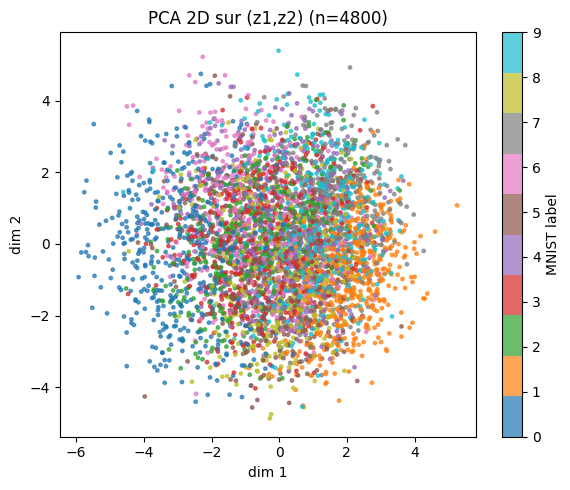

Explained var (2D): [3.256, 2.868]


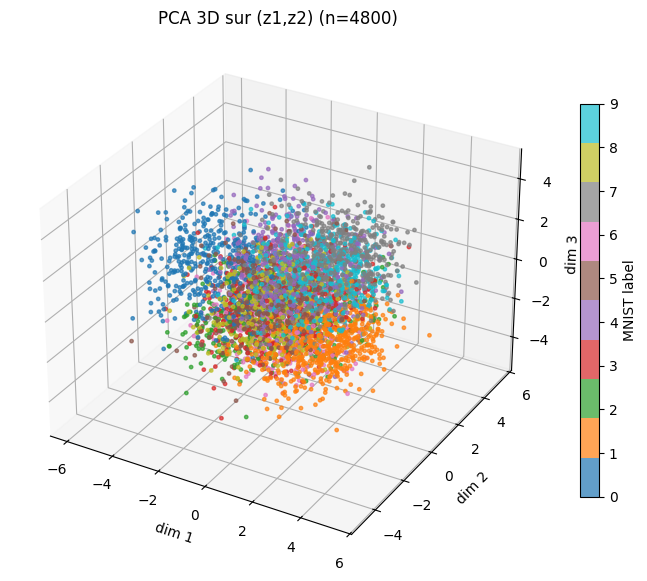

Explained var (3D): [3.256, 2.868, 2.617]


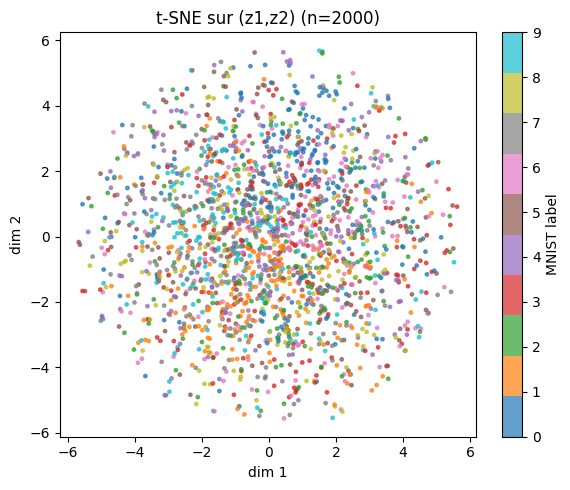

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


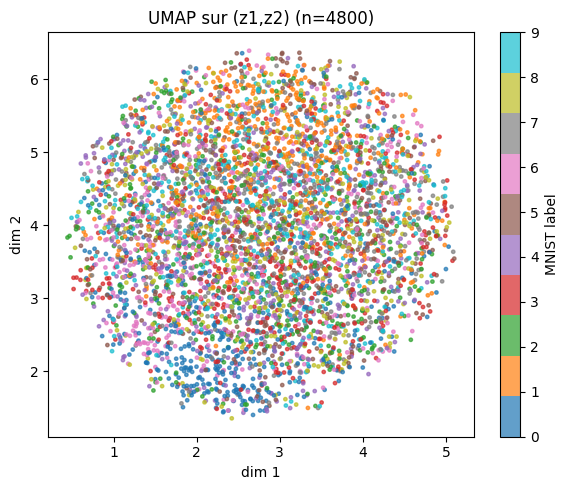

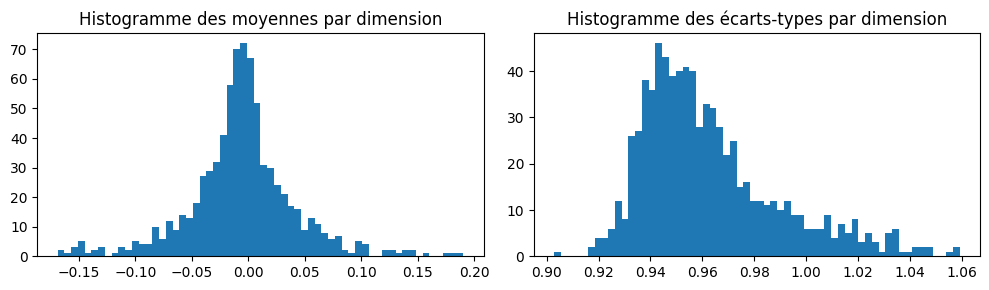

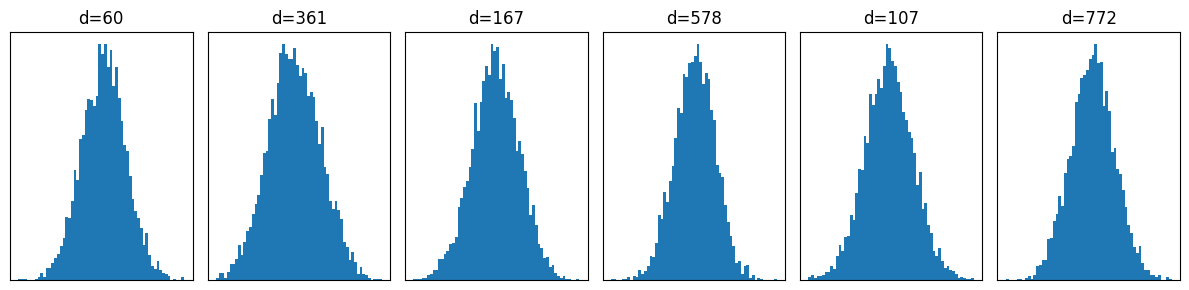

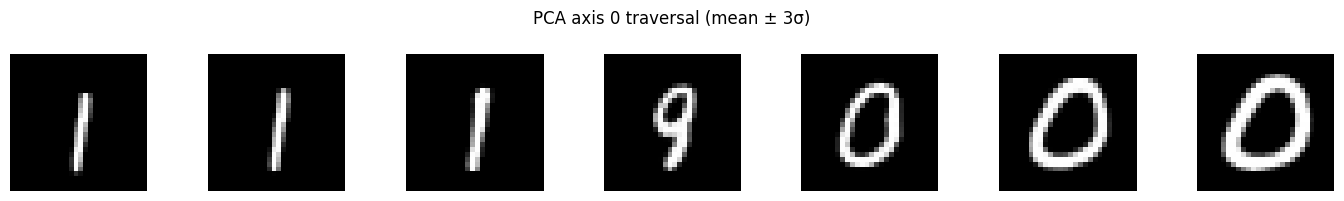

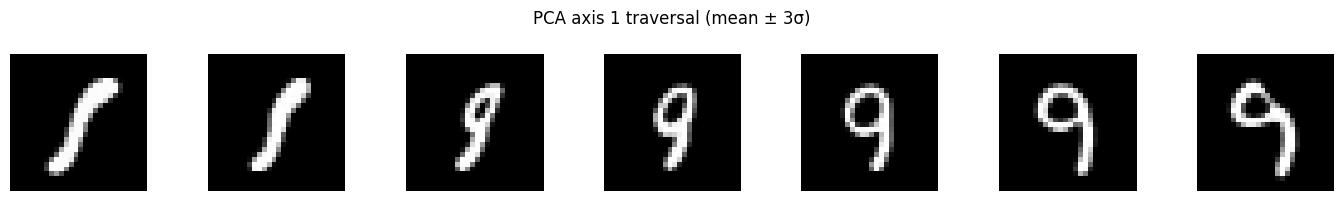

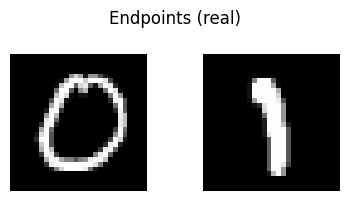

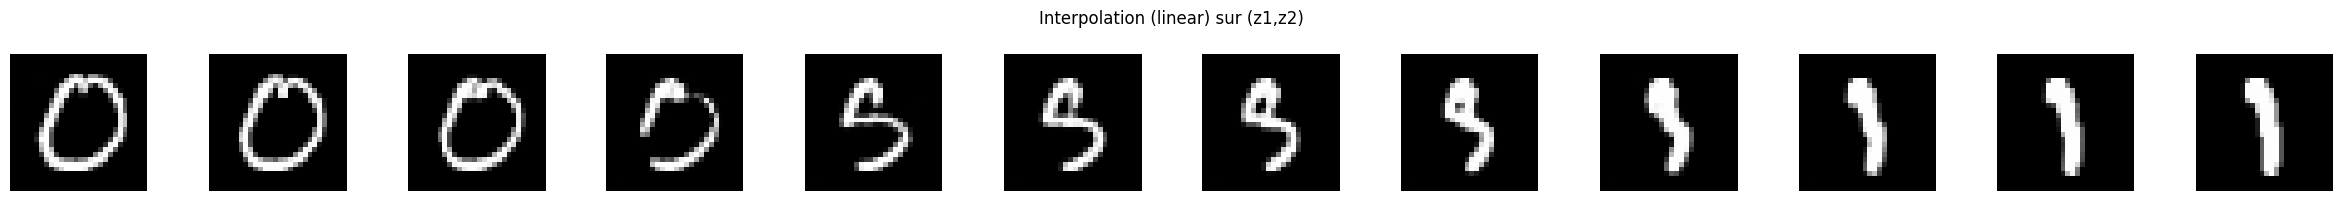

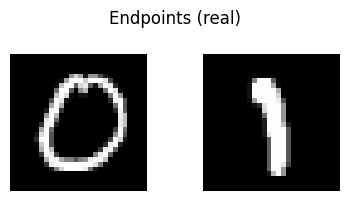

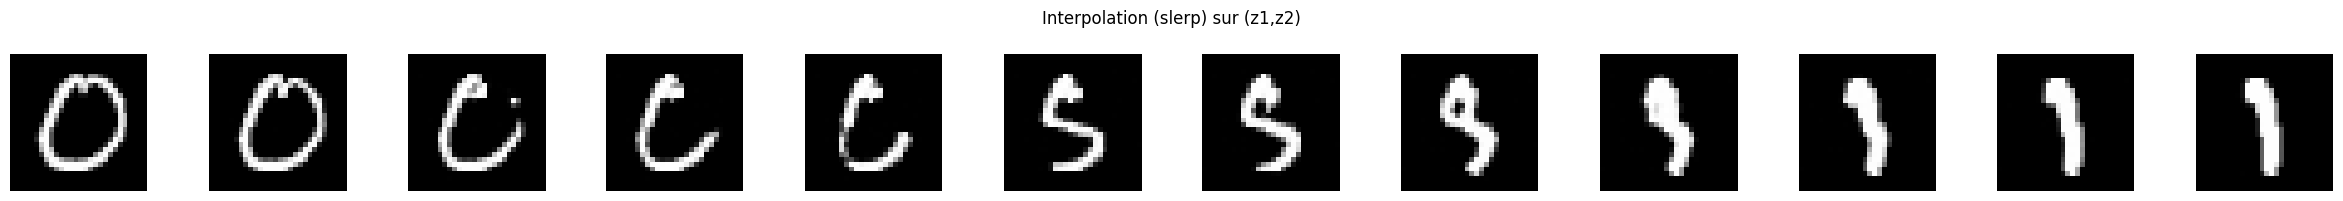

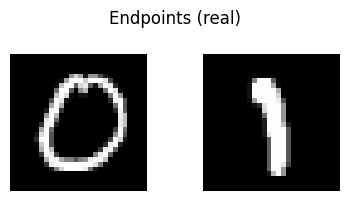

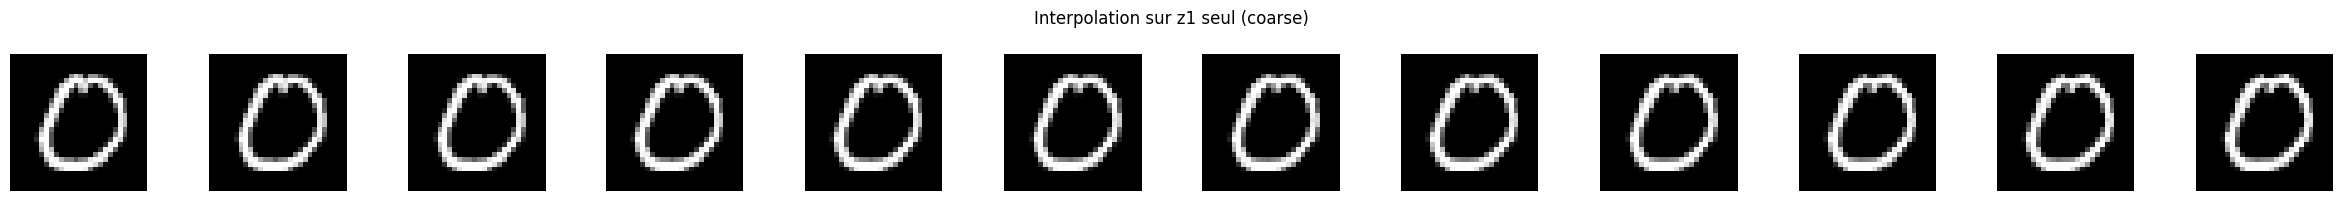

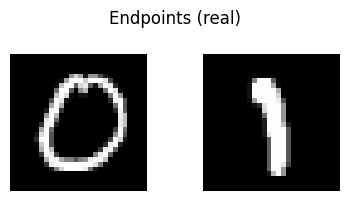

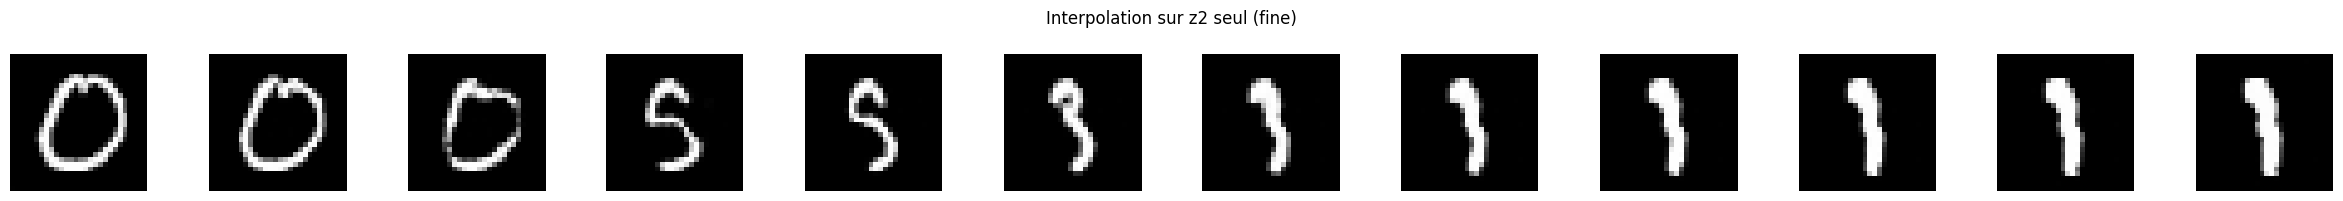

In [22]:
model = model_conv
alpha = float(cfg_conv["alpha"])

X, y, z1_shape, z2_shape = collect_latents(model, val_loader, device, alpha=alpha, max_samples=5000)
print("Latents:", X.shape, "| z1_shape=", z1_shape, "z2_shape=", z2_shape)
print("Stats globales: mean=%.3f std=%.3f" % (X.mean().item(), X.std().item()))

Z2, comps2, var2, mu = pca_torch(X, n_components=2)
plot_embedding_2d(Z2, y, title=f"PCA 2D sur (z1,z2) (n={X.size(0)})")
print("Explained var (2D):", [round(v.item(), 3) for v in var2])

Z3, comps3, var3, _ = pca_torch(X, n_components=3)
plot_embedding_3d(Z3, y, title=f"PCA 3D sur (z1,z2) (n={X.size(0)})")
print("Explained var (3D):", [round(v.item(), 3) for v in var3])

maybe_tsne(X, y, title="t-SNE sur (z1,z2)")
maybe_umap(X, y, title="UMAP sur (z1,z2)")

means = X.mean(dim=0)
stds = X.std(dim=0)
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.hist(means.numpy(), bins=60)
plt.title("Histogramme des moyennes par dimension")
plt.subplot(1, 2, 2)
plt.hist(stds.numpy(), bins=60)
plt.title("Histogramme des écarts-types par dimension")
plt.tight_layout()
plt.show()

torch.manual_seed(0)
dims = torch.randperm(X.size(1))[:6]
plt.figure(figsize=(12, 3))
for i, d in enumerate(dims.tolist()):
    plt.subplot(1, 6, i + 1)
    plt.hist(X[:, d].numpy(), bins=60, density=True)
    plt.title(f"d={d}")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

mu_flat = X.mean(dim=0).to(device)
Zk, compsk, vark, _ = pca_torch(X.to(device), n_components=2)
for k in range(2):
    component = compsk[:, k]
    component_std = float(torch.sqrt(vark[k]).item())
    decode_pca_axis_and_show(model, mu_flat, component, component_std, z1_shape, z2_shape, alpha=alpha, steps=7, scale=3.0, title=f"PCA axis {k} traversal (mean ± 3σ)",)

interpolate_latents_and_show(model, val_loader, device, idx_a=5, idx_b=12, steps=12, alpha=alpha, mode="linear", vary="both", title="Interpolation (linear) sur (z1,z2)")
interpolate_latents_and_show(model, val_loader, device, idx_a=5, idx_b=12, steps=12, alpha=alpha, mode="slerp", vary="both", title="Interpolation (slerp) sur (z1,z2)")
interpolate_latents_and_show(model, val_loader, device, idx_a=5, idx_b=12, steps=12, alpha=alpha, mode="linear", vary="z1", title="Interpolation sur z1 seul (coarse)")
interpolate_latents_and_show(model, val_loader, device, idx_a=5, idx_b=12, steps=12, alpha=alpha, mode="linear", vary="z2", title="Interpolation sur z2 seul (fine)")